In [1]:
from pathlib import Path 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns 
import numpy as np 
import json 
import plot_utils

plot_utils.set_style()

In [2]:
result_dir = Path('../results')
data_dir = Path('../data')

# Maximizing lipophilicity

### Loading, calculating

In [3]:
storage = []
for file in result_dir.glob('Lipophilicity*.json'): 
    with open(file, 'r') as f: 
        storage.extend(json.load(f))

Identify true top k and add to storage fraction of true top k information.

In [5]:
all_data = pd.read_csv(data_dir / 'Lipophilicity.csv')
all_smiles = list(all_data['smiles'])
test_data = {smi: score for smi, score in zip(all_smiles, all_data['exp'])}

k = [0.01, 0.05, 0.1, 1]
kN = [int(np.ceil(kk*len(test_data))) for kk in k]
top_smis = {kk: set(sorted(list(test_data), key = lambda smi: -1*test_data[smi])[:kk]) for kk in kN}

for entry in storage: 
    for kkN, kk in zip(kN, k): 
        entry[f'Fraction top {100*kk:0.1f}%'] = len(top_smis[kkN].intersection(set(entry["All acquired points"].keys())))/kkN
    entry.pop("All acquired points")
    entry.pop("New acquired points")

data = pd.DataFrame(storage)

### Plotting

In [6]:
fig_dir = Path('Lipophilicity')
fig_dir.mkdir(exist_ok=True, parents=True)

### Average of top k acquired 

In [9]:
data.head()

,Method,Iteration,Random seed,Top 1 ave,Top 10 ave,Top 50 ave,Top 100 ave,Fraction top 1.0%,Fraction top 5.0%,Fraction top 10.0%,Fraction top 100.0%,Objective,Dataset
0,Ours,0,0,4.2,3.582,2.0458,2.0458,0.000000,0.009524,0.011905,0.011905,NaN,NaN
1,Ours,1,0,4.5,4.159,3.4316,2.4968,0.047619,0.042857,0.040476,0.023810,exp,Lipophilicity
2,Ours,2,0,4.5,4.341,3.7894,3.2795,0.142857,0.090476,0.076190,0.035714,exp,Lipophilicity
3,Ours,3,0,4.5,4.391,3.9608,3.5953,0.190476,0.138095,0.107143,0.047619,exp,Lipophilicity
4,Ours,4,0,4.5,4.428,4.0716,3.7707,0.238095,0.185714,0.150000,0.059524,exp,Lipophilicity


ValueError: Could not interpret value `Top 0.01 ave` for `y`. An entry with this name does not appear in `data`.

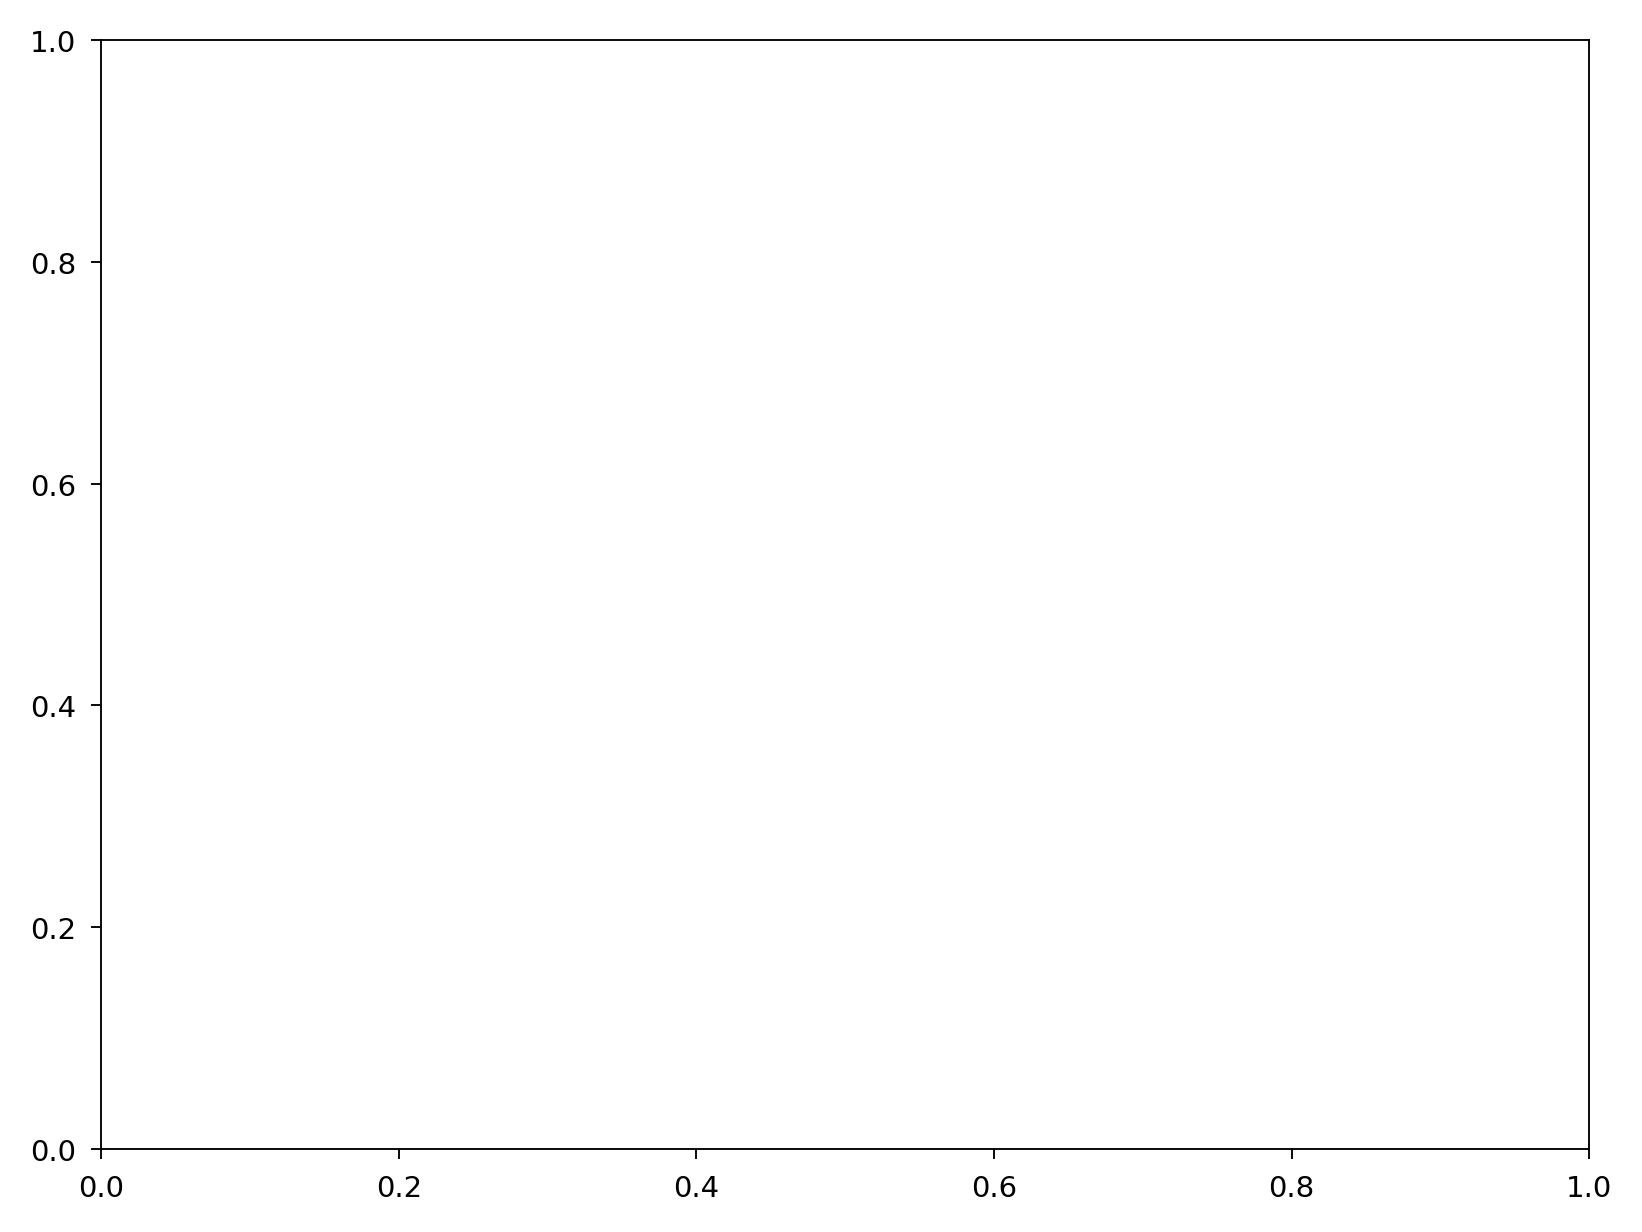

In [8]:
for kk in [1, 10, 50]:
    fig, ax = plt.subplots(1,1)
    sns.lineplot(data=data, x='Iteration', y=f'Top {kk} ave', hue='Method', style='Method', ax=ax, errorbar=('se',1))
    ax.set_ylabel(f'Average score of top {kk} acquired')
    plot_utils.set_size(w=2, h=1.5, ax=ax)
    fig.savefig(fig_dir / f'top_{kk}_average.pdf')